In [1]:
from __future__ import print_function

import os

from utils import utils
from nn_arch import nn_arch

import numpy as np
import tensorflow as tf
import sklearn.metrics
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
# Load Data
sampling_frequency=100
datafolder='./data/ptbxl/'
# task='superdiagnostic'
# task='subdiagnostic'
# task='diagnostic'
task='subdiagnostic'
outputfolder='./output/'

num_classes = 5

if (task == 'superdiagnostic'):
    num_classes = 5
elif (task == 'subdiagnostic'):
    num_classes = 23
elif (task == 'diagnostic'):
    num_classes = 44

# Load PTB-XL data
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)

# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)

# Select relevant data and convert to one-hot
data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape)
print("y_val.shape", y_val.shape)

X_train.shape (19267, 1000, 12)
y_train.shape (19267, 23)
X_val.shape (2163, 1000, 12)
y_val.shape (2163, 23)


In [3]:
# to ensure GPU use for training
if not tf.test.is_gpu_available:
    print('error')
    exit()

input_shape = X_train.shape[1:]

batch_size = 30
epochs = 30

NN_ARCH = 'resnet_11'
# NN_ARCH = 'mlp1d'
# NN_ARCH = 'cnn1d'

model = nn_arch.resnet1d(input_shape, num_classes)
# model = nn_arch.mlp1d(input_shape, num_classes)
# model = nn_arch.cnn1d(input_shape, num_classes)

X_train, X_val = utils.preprocess_signals(X_train, X_val)

In [4]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='AUC', mode='max', verbose=1, patience=2)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),\
    optimizer=\
    tf.keras.optimizers.Adam(learning_rate=0.001),\
    # tf.keras.optimizers.SGD(learning_rate=0.001),\
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', dtype=None, threshold=0.5),\
        # tf.keras.metrics.RecallAtPrecision(name='Recall', precision=0.5),
        # tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        )
    ])


history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[reduce_lr])

Epoch 1/30
643/643 [==============================] - 28s 44ms/step - loss: 0.1316 - accuracy: 0.9532 - AUC: 0.7964
Epoch 2/30
643/643 [==============================] - 28s 43ms/step - loss: 0.1145 - accuracy: 0.9570 - AUC: 0.8567
Epoch 3/30
643/643 [==============================] - 28s 43ms/step - loss: 0.1091 - accuracy: 0.9578 - AUC: 0.8718
Epoch 4/30
643/643 [==============================] - 28s 43ms/step - loss: 0.1056 - accuracy: 0.9588 - AUC: 0.8797
Epoch 5/30
643/643 [==============================] - 28s 43ms/step - loss: 0.1036 - accuracy: 0.9591 - AUC: 0.8908
Epoch 6/30
643/643 [==============================] - 28s 44ms/step - loss: 0.1015 - accuracy: 0.9596 - AUC: 0.9000
Epoch 7/30
643/643 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9598 - AUC: 0.8963
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
643/643 [==============================] - 28s 44ms/step - loss: 0.1002 - accuracy: 0.9598 - AUC: 0.8963
Epoch 8/

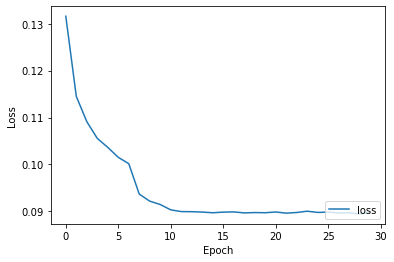

In [5]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

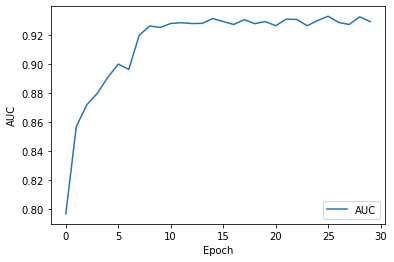

In [6]:
plt.plot(history.history['AUC'], label='AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.show()

In [7]:
model.save('./models/' + NN_ARCH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/resnet_11/assets


In [8]:
y_val_pred = model.predict(X_val)

In [9]:
import sklearn.metrics

classification_report_resnet = sklearn.metrics.classification_report(y_val, y_val_pred.round(), output_dict=True)

# conf_matrix = sklearn.metrics.multilabel_confusion_matrix(y_val, y_val_pred.round())

fpr, tpr, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_val_pred.flatten())
auc = sklearn.metrics.roc_auc_score(y_val,y_val_pred, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_val_pred.round())

precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_val_pred.round(), average='samples')

print('Tensorflow Model')
print(task + ' task')
print('\nauc:', auc)
print('hamming loss:', hamming_loss)
print('f1 score:', f1_score)

Tensorflow Model
subdiagnostic task

auc: 0.9292758364884787
hamming loss: 0.039819895877304064
f1 score: 0.5597626752966558


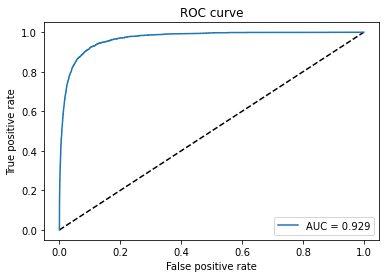

In [10]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Tensorflow Lite

In [11]:
MODELS_DIR = './models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + NN_ARCH
MODEL_NO_QUANT_TFLITE = MODELS_DIR + NN_ARCH + '_non_quantized.tflite'
MODEL_TFLITE = MODELS_DIR + NN_ARCH + '.tflite'


# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

model_tflite = converter.convert()

# # Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

1062384

In [12]:

def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  # x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # print('input: ', input_details)
  # print('\n output: ', output_details)

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  ecgs = []

  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    # new_x_test_ = x_test_[i]
    final_new_x_test_ = np.reshape(x_test_[i], (1000, 12))
    # print(np.array(list([final_new_x_test_])).shape)
    # ecgs.append(final_new_x_test_)

    
    # interpreter.resize_tensor_input(input_details['index'],[len(ecgs), 1000, 12])
    # interpreter.allocate_tensors()

    interpreter.set_tensor(input_details["index"], [final_new_x_test_])
    # interpreter.set_tensor(input_details[0]['index'], [final_new_x_test_])
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details["index"])
    ecgs.append(y_pred)
    # y_pred = interpreter.get_tensor(output_details[0]["index"])
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return ecgs

In [13]:
y_test_pred_tf = model.predict(X_val)
y_test_pred_nonquantized_tflite = predict_tflite(model_no_quant_tflite, X_val)
y_test_pred_quantized_tflite = predict_tflite(model_tflite, X_val)

In [14]:
y_test_pred_nonquantized_tflite = np.array(y_test_pred_nonquantized_tflite).reshape(-1, num_classes)
y_test_pred_quantized_tflite = np.array(y_test_pred_quantized_tflite).reshape(-1, num_classes)

In [15]:
# print(y_test_pred_tf.shape)
# print(y_test_pred_nonquantized_tflite.shape)
# print(y_test_pred_tflite.shape)

In [16]:
fpr_nonquantized, tpr_nonquantized, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_test_pred_nonquantized_tflite.flatten())
auc_tflite_nonquantized = sklearn.metrics.roc_auc_score(y_val,y_test_pred_nonquantized_tflite, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_test_pred_nonquantized_tflite.round())

precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_test_pred_nonquantized_tflite.round(), average='samples')

print('TF Lite Non-Quantized Model')
print(task + ' task')
print('\nauc:', auc_tflite_nonquantized)
print('hamming loss:', hamming_loss)
print('f1 score:', f1_score)

TF Lite Non-Quantized Model
subdiagnostic task

auc: 0.9292758364884787
hamming loss: 0.039819895877304064
f1 score: 0.5597626752966558


In [17]:
fpr_quantized, tpr_quantized, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_test_pred_quantized_tflite.flatten())
auc_tflite_quantized = sklearn.metrics.roc_auc_score(y_val,y_test_pred_quantized_tflite, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_test_pred_quantized_tflite.round())

precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_test_pred_quantized_tflite.round(), average='samples')

print('TF Lite Quantized Model')
print(task + ' task')
print('\nauc:', auc_tflite_quantized)
print('hamming loss:', hamming_loss)
print('f1 score:', f1_score)

TF Lite Quantized Model
subdiagnostic task

auc: 0.9292808577244343
hamming loss: 0.03983999678385495
f1 score: 0.5593003544459854


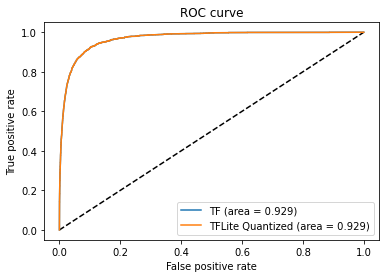

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr, label='TF (area = {:.3f})'.format(auc))
# plt.plot(fpr_nonquantized, tpr_nonquantized, label='TFLite Nonquantized (area = {:.3f})'.format(auc_tflite_nonquantized))
plt.plot(fpr_quantized, tpr_quantized, label='TFLite Quantized (area = {:.3f})'.format(auc_tflite_quantized))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [19]:
def get_size(path):
   
    #initialize the size
    total_size = 0
    
    #use the walk() method to navigate through directory tree
    for dirpath, dirnames, filenames in os.walk(path):
        for i in filenames:
            
            #use join to concatenate all the components of path
            f = os.path.join(dirpath, i)
            
            #use getsize to generate size in bytes and add it to the total size
            total_size += os.path.getsize(f)
    return total_size


size_tf = get_size('./models/' + NN_ARCH)
size_nonquan_tflite = os.stat('./models/' + NN_ARCH + '_non_quantized.tflite').st_size
size_tflite = os.stat('./models/'+ NN_ARCH +'.tflite').st_size

In [20]:
print("TF: % 2.3f" %(size_tf/1048576.), 'MB')
print("TFLite Non-quantized: % 2.3f" %(size_nonquan_tflite/1048576.), 'MB')
print("TFLite Quantized: % 2.3f" %(size_tflite/1048576.), 'MB')

TF:  7.212 MB
TFLite Non-quantized:  1.983 MB
TFLite Quantized:  1.013 MB
